# INFO 6106 - Neural Modeling: Final Project
# Lake Snow Effect using RNN and CNN models
**Submitted by:**
- Aditi Krishna
- Abhishek Shankar

Importing libraries.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import numpy as np
import pickle
import ast
from tqdm.notebook import tqdm

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

# Tensorflow
from __future__ import print_function
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import models, layers, optimizers, losses, metrics, regularizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam, SGD
# tf.config.run_functions_eagerly(True)

We read the saved data from the last notebook, where we cleaned the dataset based on different conditions.

In [2]:
filtered_les_new = pd.read_csv('updated.csv')

#### Separating the data into X and y

In [3]:
X_les = filtered_les_new.loc[:, filtered_les_new.columns != 'LES_Snowfall']
y_les = filtered_les_new['LES_Snowfall']

#### Scaling the data
Using `MinMaxScaler` to scale the features and then recreating a dataframe with same column names.

In [4]:
# Fitting MinMaxScaler()
scaler = MinMaxScaler()
idxes = X_les['idx']

# Transform data and put it together with the same indices
scaled = scaler.fit_transform(X_les)
X_les = pd.DataFrame(scaled, columns = X_les.columns.tolist())
X_les['idx'] = idxes
# X_les.drop(['Unnamed: 0'], axis=1, inplace=True)
X_les.head()

,RH_pct,Wind_Spd_mph,Wind_Direction_deg,Low_Cloud_Ht_ft,Med_Cloud_Ht_ft,High_Cloud_Ht_ft,Visibility_mi,Atm_Press_hPa,Sea_Lev_Press_hPa,Altimeter_hPa,idx
0,0.49,0.294118,0.750000,0.128571,0.0,0.0,1.0,0.976249,0.975278,0.976302,0
1,0.47,0.088235,0.000000,0.000000,0.0,0.0,1.0,0.976249,0.975182,0.976302,1
2,0.55,0.176471,0.111111,0.000000,0.0,0.0,1.0,0.976249,0.975278,0.976302,2
3,0.71,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.976249,0.975278,0.976302,3
4,0.82,0.000000,0.000000,0.285714,0.0,0.0,1.0,0.976249,0.975374,0.976302,4


# Data Preparation for RNN and CNN
### Function to prepare X & y based on the n_past hours of observations and predicting n_future hours into the future
- We assume the data to be continous
- The idea behind this data preparation function is to introduce a sliding window over the time series data
- We convert the time series dataset to be fit for a supervised learning problem
    - For example, if it is snowing at 2pm in the day then it does seem highly likely that it will snow at 3pm as well 
- In the function below we add the following parameters:
    - **n_past** : the number of hours from the past observations to consider for prediction
    - **n_future** :the number of hours into the future that we aim to predict
- `Preparing X with sliding windows`
    - The above operation takes 10 features for every hour of observation
    - After running the function, the number of observations for n_past hours gets stacked together to form a 2-D matrix, i.e., of shape $(nPast, 10)$
    - We now get 2-D matrices for the number of sliding windows possible for the set of given observations (say, k)
    - These 2-D matrices are stacked together to form a *tensor* X_train of shape $(k, nPast, 10)$
- `Preparing y with sliding windows`
    - We *assume*, that if at any hour **within** the window of now until the **n_future** hour, if the weather is that of snowing (LES_snowfall == 1), then it will snow and y will become 1, else it will be 0

## Predicting 5 days (5 x 7 hours) in advance based on 3 day (3 x 7 hours) of historical data/observation

In [5]:
n_past = 35
n_future = 21

def data_prep(X_les, y_les, n_past = n_past, n_future = n_future):
    X, y = list(), list()
    for i in range(n_past, len(X_les) - n_future): 
        '''
        1. Sliding window with 1 hour of past data and predicting 72 hours into the future
        (n_past = 1, n_future = 72)
        ==> X_les[ 1-1 : 1 ] = X_les[0 : 1]
        ==> X_les[ 2-1: 2 ] = X_les[1 : 2]
        ==> X_les[ 3-1: 3 ] = X_les[2 : 3] ...
        
        1. Sliding window with 24 hours of past data and predicting 72 hours into the future
        (n_past = 24, n_future = 72)
        ==> X_les[ 24-24 : 24 ] = X_les[0 : 24]
        ==> X_les[ 25-24: 25 ] = X_les[1 : 25]
        ==> X_les[ 26-24: 26 ] = X_les[2 : 26] ...
        '''
        # Preparing X
        # Converting each row of features from the dataframe into an array
        observations = np.array(X_les[i - n_past : i]) # 2D matrix
        # Stacking into list X 
        X.append(observations) # Tensor formed
        
        # Preparing y
        # Check if sum of all 0s and 1s from ith hour to i + future_hours > 0, then snowfall = 1
        within_sum = y_les[i : i + n_future].sum()
        if within_sum > 0:
            y.append(1)
        else:
            y.append(0)
        
    return np.array(X), np.array(y)

## Rewriting converted images and resizing to 64 x 64 (RUN ONLY ONCE!!!!)
The images are pretty large and take up a lot of memory and processing time for the network, so we decided to resize them into 64 x 64 pixels. Then, we convert the images into grayscale and save them for training. 

### Viewing the images
Let's check the saved images. 

In [6]:
a = plt.imread('images/0.png')
a.shape

(64, 64)

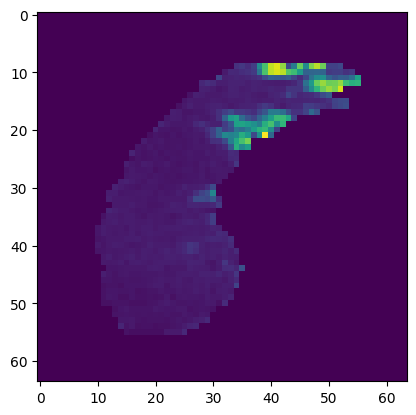

In [7]:
plt.imshow(a)

## Load images to an array for training
- We load the grayscale images in the form of array

In [8]:
from skimage.transform import rescale, resize, downscale_local_mean
import cv2

def load_images(idxs_list):
    final_images = []
    for i, idxs in enumerate(idxs_list):
        images = []
        for idx in idxs:
            # im shape -> (64, 64)
            im = cv2.imread(f'images/{int(idx)}.png')
            # Storing 1 channel, since the images are grayscale
            images.append(im[:,:,0]) 
            # images shape -> (35, 64, 64) 
        final_images.append(np.array(images)[:,:,:,None]) # Since CNN needs a color channel, here = 1
        # final_images shape -> (N, 35, 64, 64, 1) ==> 1 for grayscale
    final_images = np.array(final_images)  
    return final_images

## Data formatting (RUN ONLY ONCE and save the tensors) !!!
- Use the `data_prep` function to make sliding windows in our dataset
- Split the data
- Load and reshape the image data using the `load_images` function
- Crop images to remove extra padding from the image
- Save the transformed image and tabular data for training purpose

## Read pre-formatted images and data

In [9]:
imgs_test = np.load('images_test.npy')
imgs_train =  np.load('images_train.npy')

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

In [10]:
print(X_train.shape, y_train.shape, imgs_train.shape, X_test.shape, y_test.shape, imgs_test.shape)

(10458, 35, 10) (10458,) (10458, 35, 48, 48, 1) (3486, 35, 10) (3486,) (3486, 35, 48, 48, 1)


Let's plot the 0th image in 146th batch in grayscale:

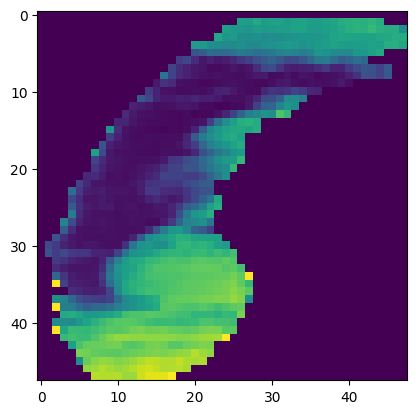

In [11]:
plt.imshow(imgs_test[146,0,:,:,0]) 

Let's plot the 0th image in 21st batch in grayscale:

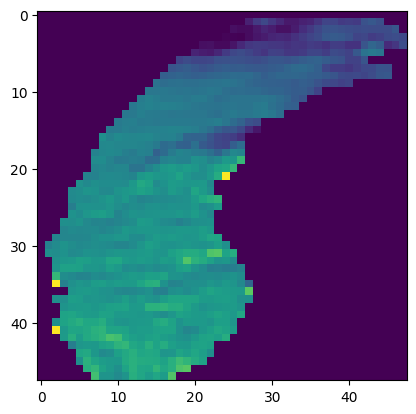

In [12]:
plt.imshow(imgs_train[21,0,:,:,0])

`Now we are ready to build our network!`

# 1. RNN using numerical meteorological data

### Long Short-Term Memory (LSTM)
**About the architecture:**
- The numerical meteorological data has 10 features and we take 35 hours (5 x 7 hours) of *n_past* observations into account in order to predict 3 days (3 x 7 hours) into the future
    - This gives the data a shape of `35 x 10`
- We enable two LSTM layers in our architecture 
    - For the first layer, we have 35 recurring LSTM blocks with each block having a dense layer of 16 neurons
    - The first layer has a `return_sequence = True`, which leads to each block returning an output resulting in 35 activations of size 16 
    - These become the input for the second LSTM layer
    - The second LSTM layer also has recurring 35 LSTM blocks of dense layers of 16 neurons, but this time the `return_sequence = False`, which means that *only* the final block gives an output of size 16 x 1
    - The final block has all the information that is necessary due to the forward propagation of information in LSTM through time
    - The final block is connected to a dense layer of one neuron, which returns a value between 0 and 1 (due to the sigmoid function)
- We use the `Adam` optimizer with a `learning_rate` of 0.01 and a `Binary Cross Entropy` function

In [13]:
RNN = layers.LSTM
data_shape = (35, 10)
data = layers.Input(shape= data_shape)

hidden_size = 16 # output shape of 1st LSTM block

# Define layers in architecture
lstm1 = RNN(hidden_size, input_shape=(35, data_shape[1]), return_sequences= True)(data)
# Using second LSTM block on top of 1st LSTM block
lstm2 = RNN(hidden_size, input_shape=(35, hidden_size), return_sequences= False)(lstm1)
# Connecting output of 2nd LSTM block with a dense layer 
# Output dense layer with 1 neuron, since we have only two possible outputs - 0/1
out = layers.Dense(1, activation='sigmoid')(lstm2)

# Optimizer
optim = Adam(learning_rate=0.01)
model = Model(data, out)  

# Compile and build model
model.compile(loss='binary_crossentropy',
              optimizer = optim,
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 35, 10)]          0         
                                                                 
 lstm (LSTM)                 (None, 35, 16)            1728      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3,857
Trainable params: 3,857
Non-trainable params: 0
_________________________________________________________________


Check shape of `X_test`:

In [14]:
X_test.shape

(3486, 35, 10)

## Training the LSTM model

In [15]:
# Init best accuracy with 0
best_acc = 0
# Save all training loss
train_loss = []
# Save all validation loss
val_loss = []
# Loop for the number of epochs
for iteration in range(100):
    print()
    print('-' * 50)
    print('Iteration:', iteration)
    
    # Loss and Acc with each epoch
    loss = []
    acc = []
    
    # Fit the model in batches of 100
    history = model.fit( X_train, y_train, batch_size = 100, epochs=1, validation_data=(X_test, y_test))
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])
    
    # If val_accuracy improves from the last saved best_accuracy, then save model
    if history.history['val_accuracy'][0] > best_acc and history.history['val_accuracy'][0] > .80:
        print('Saving Model...')
        model.save('lstm-many-to-one-data-only')
        best_acc = history.history['val_accuracy'][0]


--------------------------------------------------
Iteration: 0
105/105 [==============================] - 3s 10ms/step - loss: 0.4718 - accuracy: 0.7939 - val_loss: 0.5048 - val_accuracy: 0.7963

--------------------------------------------------
Iteration: 1
105/105 [==============================] - 1s 6ms/step - loss: 0.4535 - accuracy: 0.7940 - val_loss: 0.4530 - val_accuracy: 0.7963

--------------------------------------------------
Iteration: 2
105/105 [==============================] - 1s 5ms/step - loss: 0.4499 - accuracy: 0.7977 - val_loss: 0.4394 - val_accuracy: 0.7969

--------------------------------------------------
Iteration: 3
105/105 [==============================] - 1s 5ms/step - loss: 0.4419 - accuracy: 0.7981 - val_loss: 0.4367 - val_accuracy: 0.8046
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 4
105/105 [==============================] - 1s 6ms/step - loss: 0.4389 - accuracy: 0.7993 - val_loss: 0.4271 - val_accuracy: 0.8150
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 5
105/105 [==============================] - 1s 6ms/step - loss: 0.4291 - accuracy: 0.8026 - val_loss: 0.4193 - val_accuracy: 0.8049

--------------------------------------------------
Iteration: 6
105/105 [==============================] - 1s 6ms/step - loss: 0.4260 - accuracy: 0.8037 - val_loss: 0.4205 - val_accuracy: 0.8161
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 7
105/105 [==============================] - 1s 5ms/step - loss: 0.4214 - accuracy: 0.8029 - val_loss: 0.4130 - val_accuracy: 0.7995

--------------------------------------------------
Iteration: 8
105/105 [==============================] - 1s 6ms/step - loss: 0.4253 - accuracy: 0.8042 - val_loss: 0.4106 - val_accuracy: 0.8135

--------------------------------------------------
Iteration: 9
105/105 [==============================] - 1s 6ms/step - loss: 0.4192 - accuracy: 0.8017 - val_loss: 0.4121 - val_accuracy: 0.8084

--------------------------------------------------
Iteration: 10
105/105 [==============================] - 1s 6ms/step - loss: 0.4061 - accuracy: 0.8086 - val_loss: 0.4031 - val_accuracy: 0.8193
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 11
105/105 [==============================] - 1s 5ms/step - loss: 0.3981 - accuracy: 0.8123 - val_loss: 0.3872 - val_accuracy: 0.8107

--------------------------------------------------
Iteration: 12
105/105 [==============================] - 1s 6ms/step - loss: 0.3777 - accuracy: 0.8185 - val_loss: 0.3677 - val_accuracy: 0.8259
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 13
105/105 [==============================] - 1s 5ms/step - loss: 0.3764 - accuracy: 0.8188 - val_loss: 0.3663 - val_accuracy: 0.8296
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 14
105/105 [==============================] - 1s 5ms/step - loss: 0.3385 - accuracy: 0.8416 - val_loss: 0.3905 - val_accuracy: 0.8242

--------------------------------------------------
Iteration: 15
105/105 [==============================] - 1s 6ms/step - loss: 0.3414 - accuracy: 0.8322 - val_loss: 0.3478 - val_accuracy: 0.8345
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 16
105/105 [==============================] - 1s 5ms/step - loss: 0.3182 - accuracy: 0.8495 - val_loss: 0.3659 - val_accuracy: 0.8411
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 17
105/105 [==============================] - 1s 5ms/step - loss: 0.2850 - accuracy: 0.8670 - val_loss: 0.2810 - val_accuracy: 0.8706
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 18
105/105 [==============================] - 1s 5ms/step - loss: 0.2714 - accuracy: 0.8788 - val_loss: 0.2722 - val_accuracy: 0.8801
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 19
105/105 [==============================] - 1s 5ms/step - loss: 0.2575 - accuracy: 0.8821 - val_loss: 0.2905 - val_accuracy: 0.8597

--------------------------------------------------
Iteration: 20
105/105 [==============================] - 1s 5ms/step - loss: 0.2424 - accuracy: 0.8949 - val_loss: 0.2713 - val_accuracy: 0.8807
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 21
105/105 [==============================] - 1s 5ms/step - loss: 0.2115 - accuracy: 0.9132 - val_loss: 0.2368 - val_accuracy: 0.8916
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 22
105/105 [==============================] - 1s 5ms/step - loss: 0.2102 - accuracy: 0.9115 - val_loss: 0.2736 - val_accuracy: 0.8732

--------------------------------------------------
Iteration: 23
105/105 [==============================] - 1s 5ms/step - loss: 0.2691 - accuracy: 0.8830 - val_loss: 0.4848 - val_accuracy: 0.7960

--------------------------------------------------
Iteration: 24
105/105 [==============================] - 1s 6ms/step - loss: 0.4745 - accuracy: 0.7932 - val_loss: 0.4497 - val_accuracy: 0.7963

--------------------------------------------------
Iteration: 25
105/105 [==============================] - 1s 5ms/step - loss: 0.4520 - accuracy: 0.7927 - val_loss: 0.4346 - val_accuracy: 0.8024

--------------------------------------------------
Iteration: 26
105/105 [==============================] - 1s 5ms/step - loss: 0.4401 - accuracy: 0.7975 - val_loss: 0.4288 - val_accuracy: 0.8035

--------------

INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 60
105/105 [==============================] - 1s 5ms/step - loss: 0.2129 - accuracy: 0.8989 - val_loss: 0.2433 - val_accuracy: 0.8835

--------------------------------------------------
Iteration: 61
105/105 [==============================] - 1s 5ms/step - loss: 0.2105 - accuracy: 0.9008 - val_loss: 0.2109 - val_accuracy: 0.9002
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 62
105/105 [==============================] - 1s 6ms/step - loss: 0.1999 - accuracy: 0.9078 - val_loss: 0.2602 - val_accuracy: 0.8867

--------------------------------------------------
Iteration: 63
105/105 [==============================] - 1s 5ms/step - loss: 0.1926 - accuracy: 0.9100 - val_loss: 0.2599 - val_accuracy: 0.8878

--------------------------------------------------
Iteration: 64
105/105 [==============================] - 1s 6ms/step - loss: 0.1962 - accuracy: 0.9065 - val_loss: 0.2025 - val_accuracy: 0.9088
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 65
105/105 [==============================] - 1s 5ms/step - loss: 0.1694 - accuracy: 0.9219 - val_loss: 0.1958 - val_accuracy: 0.9171
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 66
105/105 [==============================] - 1s 5ms/step - loss: 0.1557 - accuracy: 0.9296 - val_loss: 0.1979 - val_accuracy: 0.9137

--------------------------------------------------
Iteration: 67
105/105 [==============================] - 1s 6ms/step - loss: 0.2079 - accuracy: 0.9056 - val_loss: 0.2073 - val_accuracy: 0.9068

--------------------------------------------------
Iteration: 68
105/105 [==============================] - 1s 5ms/step - loss: 0.1606 - accuracy: 0.9247 - val_loss: 0.1967 - val_accuracy: 0.9111

--------------------------------------------------
Iteration: 69
105/105 [==============================] - 1s 5ms/step - loss: 0.2017 - accuracy: 0.9121 - val_loss: 0.2636 - val_accuracy: 0.8898

--------------------------------------------------
Iteration: 70
105/105 [==============================] - 1s 5ms/step - loss: 0.1549 - accuracy: 0.9316 - val_loss: 0.2079 - val_accuracy: 0.9065

--------------

INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 72
105/105 [==============================] - 1s 5ms/step - loss: 0.1415 - accuracy: 0.9381 - val_loss: 0.2115 - val_accuracy: 0.9119

--------------------------------------------------
Iteration: 73
105/105 [==============================] - 1s 5ms/step - loss: 0.1573 - accuracy: 0.9312 - val_loss: 0.1680 - val_accuracy: 0.9323
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 74
105/105 [==============================] - 1s 6ms/step - loss: 0.1249 - accuracy: 0.9465 - val_loss: 0.1803 - val_accuracy: 0.9214

--------------------------------------------------
Iteration: 75
105/105 [==============================] - 1s 5ms/step - loss: 0.1386 - accuracy: 0.9385 - val_loss: 0.1770 - val_accuracy: 0.9225

--------------------------------------------------
Iteration: 76
105/105 [==============================] - 1s 5ms/step - loss: 0.1364 - accuracy: 0.9403 - val_loss: 0.1678 - val_accuracy: 0.9297

--------------------------------------------------
Iteration: 77
105/105 [==============================] - 1s 5ms/step - loss: 0.1508 - accuracy: 0.9357 - val_loss: 0.1554 - val_accuracy: 0.9355
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 78
105/105 [==============================] - 1s 5ms/step - loss: 0.1309 - accuracy: 0.9449 - val_loss: 0.1604 - val_accuracy: 0.9355

--------------------------------------------------
Iteration: 79
105/105 [==============================] - 1s 5ms/step - loss: 0.1145 - accuracy: 0.9514 - val_loss: 0.2346 - val_accuracy: 0.9148

--------------------------------------------------
Iteration: 80
105/105 [==============================] - 1s 6ms/step - loss: 0.1774 - accuracy: 0.9269 - val_loss: 0.1618 - val_accuracy: 0.9309

--------------------------------------------------
Iteration: 81
105/105 [==============================] - 1s 5ms/step - loss: 0.1731 - accuracy: 0.9281 - val_loss: 0.2017 - val_accuracy: 0.9114

--------------------------------------------------
Iteration: 82
105/105 [==============================] - 1s 6ms/step - loss: 0.1214 - accuracy: 0.9502 - val_loss: 0.1600 - val_accuracy: 0.9375
Saving Model...

INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 83
105/105 [==============================] - 1s 6ms/step - loss: 0.1299 - accuracy: 0.9466 - val_loss: 0.2129 - val_accuracy: 0.9131

--------------------------------------------------
Iteration: 84
105/105 [==============================] - 1s 6ms/step - loss: 0.1549 - accuracy: 0.9383 - val_loss: 0.1509 - val_accuracy: 0.9375

--------------------------------------------------
Iteration: 85
105/105 [==============================] - 1s 6ms/step - loss: 0.1040 - accuracy: 0.9563 - val_loss: 0.1430 - val_accuracy: 0.9446
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 86
105/105 [==============================] - 1s 5ms/step - loss: 0.1206 - accuracy: 0.9489 - val_loss: 0.1710 - val_accuracy: 0.9398

--------------------------------------------------
Iteration: 87
105/105 [==============================] - 1s 5ms/step - loss: 0.1087 - accuracy: 0.9571 - val_loss: 0.1646 - val_accuracy: 0.9357

--------------------------------------------------
Iteration: 88
105/105 [==============================] - 1s 5ms/step - loss: 0.1006 - accuracy: 0.9611 - val_loss: 0.1536 - val_accuracy: 0.9429

--------------------------------------------------
Iteration: 89
105/105 [==============================] - 1s 5ms/step - loss: 0.2074 - accuracy: 0.9220 - val_loss: 0.2625 - val_accuracy: 0.8864

--------------------------------------------------
Iteration: 90
105/105 [==============================] - 1s 5ms/step - loss: 0.1269 - accuracy: 0.9500 - val_loss: 0.1554 - val_accuracy: 0.9372

--------------

INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-only/assets



--------------------------------------------------
Iteration: 95
105/105 [==============================] - 1s 6ms/step - loss: 0.0881 - accuracy: 0.9656 - val_loss: 0.1786 - val_accuracy: 0.9283

--------------------------------------------------
Iteration: 96
105/105 [==============================] - 1s 6ms/step - loss: 0.0973 - accuracy: 0.9617 - val_loss: 0.1565 - val_accuracy: 0.9415

--------------------------------------------------
Iteration: 97
105/105 [==============================] - 1s 5ms/step - loss: 0.0825 - accuracy: 0.9691 - val_loss: 0.1452 - val_accuracy: 0.9455

--------------------------------------------------
Iteration: 98
105/105 [==============================] - 1s 5ms/step - loss: 0.0902 - accuracy: 0.9636 - val_loss: 0.1723 - val_accuracy: 0.9355

--------------------------------------------------
Iteration: 99
105/105 [==============================] - 1s 5ms/step - loss: 0.1007 - accuracy: 0.9615 - val_loss: 0.1771 - val_accuracy: 0.9300


## Plotting Epochs vs. Training loss (Binary Cross Entropy)

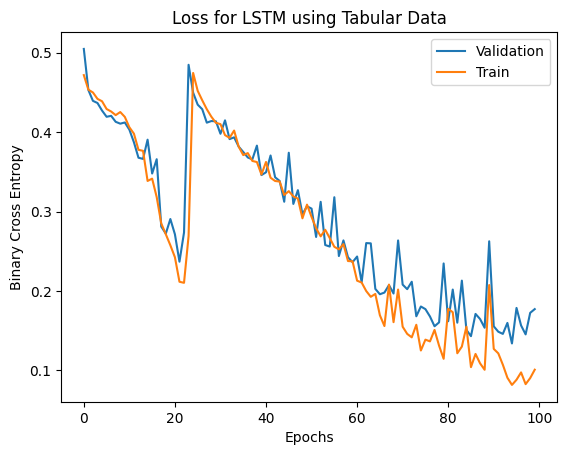

In [16]:
plt.plot(val_loss, label='Validation')
plt.plot(train_loss, label='Train')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Loss for LSTM using Tabular Data')
plt.savefig('Losses_data_only.png')

The training loss and validation loss has decreased monotonically, with one peak.

## Testing the model on the test set

In [17]:
from tensorflow import keras

# Loading the model
model_pretrained = keras.models.load_model('lstm-many-to-one-data-only')

# Prediction using X_test
pred = model_pretrained(X_test)
# Convert to array
pred = np.array(pred)

# Assigning class based on prediction
pred[pred > 0.5] = 1
pred[pred != 1] = 0

# Class-wise accuracy
classwise1 = ((np.array(pred)[:,0] == np.array(y_test))*(y_test==1)).sum()/(y_test==1).sum()
classwise0 = ((np.array(pred)[:,0] == np.array(y_test))*(y_test==0)).sum()/(y_test==0).sum()

## Classwise accuracy and overall accuracy on test data 

In [18]:
print(f'Total Accuracy: \t {((np.array(pred)[:,0] == np.array(y_test)).sum()/len(pred))*100:.3f}')
print('-'*30)

print('--Class wise Accuracy of Test--')
print('-'*30)
print(f'Class 0: \t {classwise0*100:.3f}')
print(f'Class 1: \t {classwise1*100:.3f}')

Total Accuracy: 	 94.923
------------------------------
--Class wise Accuracy of Test--
------------------------------
Class 0: 	 97.586
Class 1: 	 84.507


# 2. Combination model with CNN and RNN using satellite images and numerical meteorological data

**About the architecture:**
- First, we stack the images in channels (i.e. 1 channel for grayscale), and then pass them through multiple layers of Convolutions with kernel/filter size 3 x 3 and stride 2 x 2
- To be precise, we use 6 convolution layers with 3, 6, 6, 8, 8, 8 filter counts at respective layers
- By keeping zero padding and stride 2 x 2, we reduce the image size by half through each layer, resulting in final activation size as 1 x 1 x 8 (i.e. output of final convolution layer)
- We then flatten this output and concatenate them with the 1 x 16 dimension output of LSTM that we discussed in the previous section
- Finally, we use a dense layer with 1 neuron to predict the output between 0 and 1 (due to the sigmoid activation)

**Intuition:**
- By concatenating the output from the ConvNet to the LSTM output, we infuse the information from images with the tabular data which in turn provides more information to predict the decision boundary
- We stack multiple convolution layers to enable complex feature extraction
- The convolution filters in the channel depth learn to fuse the information in time domain, as we stack the temporal frames in channels
- More intuitively, these act as a fully connected LSTM layers rather than feedforward LSTM layers

In [19]:
RNN = layers.LSTM
img_shape = (48, 48, 35)
data_shape = (35, 10)

image = layers.Input(shape=img_shape)
data = layers.Input(shape= data_shape)

# Define the CNN for images
# filter => 3x3
# stride => 2x2
conv1 = layers.Conv2D(3, (3, 3), (2,2), padding='same', activation='selu')(image)
conv2 = layers.Conv2D(6, (3, 3), (2,2), padding='same', activation='selu')(conv1)
conv3 = layers.Conv2D(6, (3, 3), (2,2), padding='same', activation='selu')(conv2)
conv4 = layers.Conv2D(8, (3, 3), (2,2), padding='same', activation='selu')(conv3)
conv5 = layers.Conv2D(8, (3, 3), (2,2), padding='same', activation='selu')(conv4)
conv6 = layers.Conv2D(8, (3, 3), (2,2), padding='same', activation='selu')(conv5)

# LSTM neurons
hidden_size = 16

# Define layers in RNN
lstm1 = RNN(hidden_size, input_shape=(35, data_shape[1]), return_sequences= True)(data)
lstm2 = RNN(hidden_size, input_shape=(35, hidden_size), return_sequences= False)(lstm1)

# Flatten the output of CNN
flattened = layers.Flatten()(conv6)

# Connect the CNN output and RNN output to a dense layer with 1 neuron for final 0/1 outputs
final = layers.Concatenate(axis=1)([lstm2, flattened])
out = layers.Dense(1, activation='sigmoid')(final)

# Using both, images and numerical data as input
model = Model([image, data], out)  

# Optimizer
optim = Adam(learning_rate=0.01)

# Build model
model.compile(loss='binary_crossentropy',
              optimizer = optim,
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 35)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 24, 24, 3)    948         ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 12, 12, 6)    168         ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 6, 6, 6)      330         ['conv2d_1[0][0]']         

## Training the CNN + RNN Combination model

In [20]:
imgs_test = np.load('images_test.npy')
imgs_train =  np.load('images_train.npy')

In [21]:
# Init best accuracy with 0
best_acc = 0
# Save all training loss
train_loss = []
# Save all validation loss
val_loss = []
# reshape imgs_train and imgs_test
imgs_train = np.einsum('ijkl->iklj', imgs_train[:,:,:,:,0])
imgs_test = np.einsum('ijkl->iklj', imgs_test[:,:,:,:,0])
# Loop for the number of epochs
for iteration in range(100):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    
    # Loss and Acc with each epoch
    loss = []
    acc = []
    
    # Fit the model in batches of 100
    history = model.fit( [imgs_train, X_train], y_train, batch_size = 100, epochs=1, validation_data=( [imgs_test, X_test], y_test))
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])
    # If val_accuracy improves from the last saved best_accuracy, then save model
    if history.history['val_accuracy'][0] > best_acc and history.history['val_accuracy'][0] > .80:
        print('Saving Model...')
        model.save('lstm-many-to-one-data-and-images')
        best_acc = history.history['val_accuracy'][0]


--------------------------------------------------
Iteration 0
105/105 [==============================] - 4s 17ms/step - loss: 0.4905 - accuracy: 0.7882 - val_loss: 0.4556 - val_accuracy: 0.7963

--------------------------------------------------
Iteration 1
105/105 [==============================] - 1s 10ms/step - loss: 0.4528 - accuracy: 0.7955 - val_loss: 0.4395 - val_accuracy: 0.8075
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 2
105/105 [==============================] - 1s 10ms/step - loss: 0.4469 - accuracy: 0.7983 - val_loss: 0.4393 - val_accuracy: 0.7966

--------------------------------------------------
Iteration 3
105/105 [==============================] - 1s 10ms/step - loss: 0.4383 - accuracy: 0.8000 - val_loss: 0.4241 - val_accuracy: 0.8061

--------------------------------------------------
Iteration 4
105/105 [==============================] - 1s 10ms/step - loss: 0.4295 - accuracy: 0.8026 - val_loss: 0.4373 - val_accuracy: 0.8101
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 5
105/105 [==============================] - 1s 10ms/step - loss: 0.4299 - accuracy: 0.8050 - val_loss: 0.4194 - val_accuracy: 0.8138
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 6
105/105 [==============================] - 1s 10ms/step - loss: 0.4184 - accuracy: 0.8072 - val_loss: 0.4120 - val_accuracy: 0.8101

--------------------------------------------------
Iteration 7
105/105 [==============================] - 1s 10ms/step - loss: 0.4092 - accuracy: 0.8147 - val_loss: 0.4087 - val_accuracy: 0.8118

--------------------------------------------------
Iteration 8
105/105 [==============================] - 1s 10ms/step - loss: 0.4087 - accuracy: 0.8088 - val_loss: 0.4087 - val_accuracy: 0.8150
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 9
105/105 [==============================] - 1s 10ms/step - loss: 0.3878 - accuracy: 0.8179 - val_loss: 0.4104 - val_accuracy: 0.7966

--------------------------------------------------
Iteration 10
105/105 [==============================] - 1s 10ms/step - loss: 0.3740 - accuracy: 0.8202 - val_loss: 0.3825 - val_accuracy: 0.8250
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 11
105/105 [==============================] - 1s 10ms/step - loss: 0.3581 - accuracy: 0.8312 - val_loss: 0.3432 - val_accuracy: 0.8419
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 12
105/105 [==============================] - 1s 10ms/step - loss: 0.3413 - accuracy: 0.8413 - val_loss: 0.4830 - val_accuracy: 0.7952

--------------------------------------------------
Iteration 13
105/105 [==============================] - 1s 10ms/step - loss: 0.4736 - accuracy: 0.7943 - val_loss: 0.4465 - val_accuracy: 0.7969

--------------------------------------------------
Iteration 14
105/105 [==============================] - 1s 10ms/step - loss: 0.4447 - accuracy: 0.7985 - val_loss: 0.4370 - val_accuracy: 0.8110

--------------------------------------------------
Iteration 15
105/105 [==============================] - 1s 11ms/step - loss: 0.4510 - accuracy: 0.7983 - val_loss: 0.4314 - val_accuracy: 0.8107

--------------------------------------------------
Iteration 16
105/105 [==============================] - 1s 10ms/step - loss: 0.4370 - accuracy: 0.7972 - val_loss: 0.4282 - val_accuracy: 0.8118

--------------

INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 26
105/105 [==============================] - 1s 10ms/step - loss: 0.3545 - accuracy: 0.8354 - val_loss: 0.3445 - val_accuracy: 0.8405

--------------------------------------------------
Iteration 27
105/105 [==============================] - 1s 10ms/step - loss: 0.3302 - accuracy: 0.8478 - val_loss: 0.3386 - val_accuracy: 0.8437
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 28
105/105 [==============================] - 1s 10ms/step - loss: 0.3223 - accuracy: 0.8502 - val_loss: 0.3491 - val_accuracy: 0.8319

--------------------------------------------------
Iteration 29
105/105 [==============================] - 1s 10ms/step - loss: 0.2930 - accuracy: 0.8679 - val_loss: 0.3041 - val_accuracy: 0.8592
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 30
105/105 [==============================] - 1s 10ms/step - loss: 0.2690 - accuracy: 0.8789 - val_loss: 0.3042 - val_accuracy: 0.8715
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 31
105/105 [==============================] - 1s 10ms/step - loss: 0.2516 - accuracy: 0.8870 - val_loss: 0.2490 - val_accuracy: 0.8887
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 32
105/105 [==============================] - 1s 11ms/step - loss: 0.2396 - accuracy: 0.8939 - val_loss: 0.2618 - val_accuracy: 0.8781

--------------------------------------------------
Iteration 33
105/105 [==============================] - 1s 10ms/step - loss: 0.2199 - accuracy: 0.9061 - val_loss: 0.2167 - val_accuracy: 0.9048
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 34
105/105 [==============================] - 1s 10ms/step - loss: 0.2071 - accuracy: 0.9137 - val_loss: 0.1995 - val_accuracy: 0.9105
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 35
105/105 [==============================] - 1s 10ms/step - loss: 0.1931 - accuracy: 0.9195 - val_loss: 0.2084 - val_accuracy: 0.9073

--------------------------------------------------
Iteration 36
105/105 [==============================] - 1s 10ms/step - loss: 0.1763 - accuracy: 0.9265 - val_loss: 0.2437 - val_accuracy: 0.8916

--------------------------------------------------
Iteration 37
105/105 [==============================] - 1s 10ms/step - loss: 0.1822 - accuracy: 0.9232 - val_loss: 0.1746 - val_accuracy: 0.9237
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 38
105/105 [==============================] - 1s 10ms/step - loss: 0.1532 - accuracy: 0.9341 - val_loss: 0.1748 - val_accuracy: 0.9277
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 39
105/105 [==============================] - 1s 10ms/step - loss: 0.1554 - accuracy: 0.9361 - val_loss: 0.1655 - val_accuracy: 0.9297
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 40
105/105 [==============================] - 1s 10ms/step - loss: 0.1494 - accuracy: 0.9413 - val_loss: 0.1538 - val_accuracy: 0.9355
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 41
105/105 [==============================] - 1s 10ms/step - loss: 0.1318 - accuracy: 0.9478 - val_loss: 0.1361 - val_accuracy: 0.9429
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 42
105/105 [==============================] - 1s 10ms/step - loss: 0.1136 - accuracy: 0.9570 - val_loss: 0.1223 - val_accuracy: 0.9507
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 43
105/105 [==============================] - 1s 10ms/step - loss: 0.1047 - accuracy: 0.9592 - val_loss: 0.1410 - val_accuracy: 0.9418

--------------------------------------------------
Iteration 44
105/105 [==============================] - 1s 10ms/step - loss: 0.1246 - accuracy: 0.9518 - val_loss: 0.1180 - val_accuracy: 0.9552
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 45
105/105 [==============================] - 1s 11ms/step - loss: 0.1392 - accuracy: 0.9419 - val_loss: 0.1868 - val_accuracy: 0.9205

--------------------------------------------------
Iteration 46
105/105 [==============================] - 1s 10ms/step - loss: 0.1432 - accuracy: 0.9411 - val_loss: 0.1492 - val_accuracy: 0.9395

--------------------------------------------------
Iteration 47
105/105 [==============================] - 1s 10ms/step - loss: 0.1152 - accuracy: 0.9524 - val_loss: 0.1055 - val_accuracy: 0.9575
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 48
105/105 [==============================] - 1s 10ms/step - loss: 0.1014 - accuracy: 0.9607 - val_loss: 0.1112 - val_accuracy: 0.9593
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 49
105/105 [==============================] - 1s 10ms/step - loss: 0.0911 - accuracy: 0.9648 - val_loss: 0.1387 - val_accuracy: 0.9438

--------------------------------------------------
Iteration 50
105/105 [==============================] - 1s 10ms/step - loss: 0.0886 - accuracy: 0.9670 - val_loss: 0.1024 - val_accuracy: 0.9621
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 51
105/105 [==============================] - 1s 10ms/step - loss: 0.0850 - accuracy: 0.9675 - val_loss: 0.1151 - val_accuracy: 0.9558

--------------------------------------------------
Iteration 52
105/105 [==============================] - 1s 10ms/step - loss: 0.0791 - accuracy: 0.9701 - val_loss: 0.1338 - val_accuracy: 0.9487

--------------------------------------------------
Iteration 53
105/105 [==============================] - 1s 10ms/step - loss: 0.0781 - accuracy: 0.9692 - val_loss: 0.2686 - val_accuracy: 0.9056

--------------------------------------------------
Iteration 54
105/105 [==============================] - 1s 10ms/step - loss: 0.4457 - accuracy: 0.7951 - val_loss: 0.3583 - val_accuracy: 0.8216

--------------------------------------------------
Iteration 55
105/105 [==============================] - 1s 10ms/step - loss: 0.3204 - accuracy: 0.8308 - val_loss: 0.2826 - val_accuracy: 0.8543

--------------

INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 73
105/105 [==============================] - 1s 10ms/step - loss: 0.0672 - accuracy: 0.9734 - val_loss: 0.0913 - val_accuracy: 0.9650

--------------------------------------------------
Iteration 74
105/105 [==============================] - 1s 10ms/step - loss: 0.0804 - accuracy: 0.9703 - val_loss: 0.0753 - val_accuracy: 0.9707
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 75
105/105 [==============================] - 1s 10ms/step - loss: 0.0608 - accuracy: 0.9760 - val_loss: 0.0992 - val_accuracy: 0.9650

--------------------------------------------------
Iteration 76
105/105 [==============================] - 1s 10ms/step - loss: 0.0660 - accuracy: 0.9752 - val_loss: 0.0778 - val_accuracy: 0.9702

--------------------------------------------------
Iteration 77
105/105 [==============================] - 1s 10ms/step - loss: 0.0596 - accuracy: 0.9782 - val_loss: 0.0795 - val_accuracy: 0.9673

--------------------------------------------------
Iteration 78
105/105 [==============================] - 1s 10ms/step - loss: 0.0566 - accuracy: 0.9778 - val_loss: 0.0709 - val_accuracy: 0.9739
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 79
105/105 [==============================] - 1s 10ms/step - loss: 0.0703 - accuracy: 0.9728 - val_loss: 0.1212 - val_accuracy: 0.9507

--------------------------------------------------
Iteration 80
105/105 [==============================] - 1s 10ms/step - loss: 0.0506 - accuracy: 0.9800 - val_loss: 0.0735 - val_accuracy: 0.9716

--------------------------------------------------
Iteration 81
105/105 [==============================] - 1s 11ms/step - loss: 0.0409 - accuracy: 0.9858 - val_loss: 0.0640 - val_accuracy: 0.9745
Saving Model...


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 82
105/105 [==============================] - 1s 10ms/step - loss: 0.0705 - accuracy: 0.9731 - val_loss: 0.0753 - val_accuracy: 0.9705

--------------------------------------------------
Iteration 83
105/105 [==============================] - 1s 10ms/step - loss: 0.0501 - accuracy: 0.9803 - val_loss: 0.0698 - val_accuracy: 0.9707

--------------------------------------------------
Iteration 84
105/105 [==============================] - 1s 10ms/step - loss: 0.0780 - accuracy: 0.9721 - val_loss: 0.0765 - val_accuracy: 0.9719

--------------------------------------------------
Iteration 85
105/105 [==============================] - 1s 10ms/step - loss: 0.1259 - accuracy: 0.9526 - val_loss: 0.2687 - val_accuracy: 0.8973

--------------------------------------------------
Iteration 86
105/105 [==============================] - 1s 10ms/step - loss: 0.1139 - accuracy: 0.9550 - val_loss: 0.0802 - val_accuracy: 0.9639

--------------

INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 90
105/105 [==============================] - 1s 10ms/step - loss: 0.0617 - accuracy: 0.9791 - val_loss: 0.1349 - val_accuracy: 0.9527

--------------------------------------------------
Iteration 91
105/105 [==============================] - 1s 10ms/step - loss: 0.0612 - accuracy: 0.9760 - val_loss: 0.0739 - val_accuracy: 0.9710

--------------------------------------------------
Iteration 92
105/105 [==============================] - 1s 10ms/step - loss: 0.0368 - accuracy: 0.9865 - val_loss: 0.0972 - val_accuracy: 0.9630

--------------------------------------------------
Iteration 93
105/105 [==============================] - 1s 10ms/step - loss: 0.0450 - accuracy: 0.9842 - val_loss: 0.1077 - val_accuracy: 0.9613

--------------------------------------------------
Iteration 94
105/105 [==============================] - 1s 10ms/step - loss: 0.0511 - accuracy: 0.9814 - val_loss: 0.0787 - val_accuracy: 0.9699

--------------

INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets


INFO:tensorflow:Assets written to: lstm-many-to-one-data-and-images/assets



--------------------------------------------------
Iteration 98
105/105 [==============================] - 1s 10ms/step - loss: 0.0483 - accuracy: 0.9836 - val_loss: 0.1242 - val_accuracy: 0.9541

--------------------------------------------------
Iteration 99
105/105 [==============================] - 1s 10ms/step - loss: 0.0779 - accuracy: 0.9700 - val_loss: 0.0953 - val_accuracy: 0.9644


## Plotting Epochs vs. Training loss (Binary Cross Entropy)

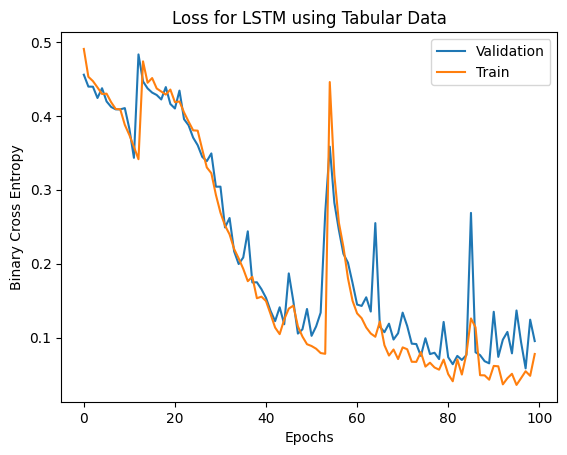

In [22]:
plt.plot(val_loss, label='Validation')
plt.plot(train_loss, label='Train')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.title('Loss for LSTM using Tabular Data')
plt.savefig('Losses_data_and_image.png')

The training loss and validation loss has decreased monotonically, with one peak.

## Testing the model on the test set

In [23]:
# Loading the model
model_pretrained = keras.models.load_model('lstm-many-to-one-data-and-images')

# Prediction using X_test
pred = model_pretrained([imgs_test, X_test])
# Convert to array
pred = np.array(pred)

# Assigning class based on prediction
pred[pred>0.5] = 1
pred[pred!=1] = 0

# Class-wise accuracy
classwise1 = ((np.array(pred)[:,0] == np.array(y_test))*(y_test==1)).sum()/(y_test==1).sum()
classwise0 = ((np.array(pred)[:,0] == np.array(y_test))*(y_test==0)).sum()/(y_test==0).sum()

## Classwise accuracy and overall accuracy on test data 

In [24]:
print(f'Total Accuracy: \t {((np.array(pred)[:,0] == np.array(y_test)).sum()/len(pred))*100:.3f}')
print('-'*30)
print('--Class wise Accuracy of Test--')
print('-'*30)
print(f'Class 0: \t {classwise0*100:.3f}')
print(f'Class 1: \t {classwise1*100:.3f}')

Total Accuracy: 	 97.762
------------------------------
--Class wise Accuracy of Test--
------------------------------
Class 0: 	 98.199
Class 1: 	 96.056


# Conclusion:

- The RNN model and the CNN + RNN combination model, both work very well (>90%)
    - But due to the images data and ConvNets, the combination model shows a substantial improvement in testing accuracy of 97% compared to 94 % of RNN model.
    - We mainly find a major improvement in class wise accuracies. As the combined CNN+RNN model has 96% accuracy for snow prediction while the RNN model has 84.5% (almost a +12% boost!) 
- **RNN**
    - Total Accuracy = `94.923%`
    - Class-wise Accuracy
        - Class 0 = 97.586%
        - Class 1 = 84.507%
- **CNN + RNN**
    - Total Accuracy = `97.762%`
    - Class-wise Accuracy
        - Class 0 = 98.199%
        - Class 1 = 96.056%
- Our baseline of Decision Tree had an accuracy of `54.76%`
    - Overall, our CNN + RNN network has shown an improvement of `~42%`

# Reference
- Zeiler. et.al 2013, "Visualizing and Understanding Convolutional Networks" (https://arxiv.org/abs/1311.2901)
- https://medium.com/@mixanyy/different-ways-to-combine-cnn-and-lstm-networks-for-time-series-classification-tasks-b03fc37e91b6